In [1]:
import numpy as np
import pandas as pd
from validphys.api import API

import matplotlib.pyplot as plt
from matplotlib import patches, transforms, rc
from matplotlib.patches import Ellipse

import scipy
rc("font", **{"family": "sans-serif", "sans-serif": ["Helvetica"], "size": 20})
rc("text", **{"usetex": True, "latex.preamble": r"\usepackage{amssymb}"})

fitname = "250519-jth-exa-nnlo-alphas_mt_y_tcm_iterated"
fit = API.fit(fit=fitname)

In [2]:
pdf_indices = API.fitted_replica_indexes(pdf=fit.name)

LHAPDF 6.5.5 loading /Users/jaco/miniconda3/envs/nnpdf_dev/share/LHAPDF/250519-jth-exa-nnlo-alphas_mt_y_tcm/250519-jth-exa-nnlo-alphas_mt_y_tcm_0000.dat
250519-jth-exa-nnlo-alphas_mt_y_tcm PDF set, member #0, version 1


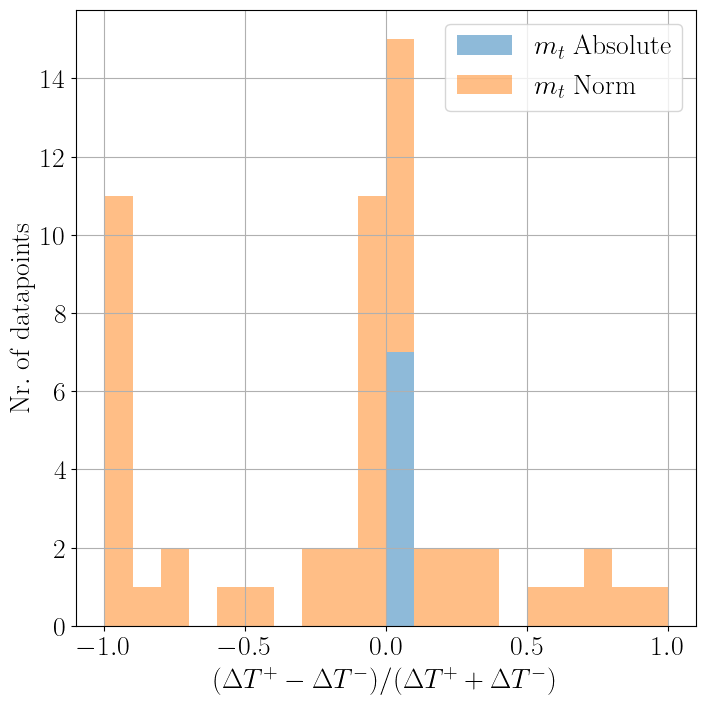

In [3]:
# We have to know the name of the alphas and mtop point prescriptions (alphas_pp and mtop_pp) to
# extract the theoryids. We need alphas_pp_id and mtop_pp_id to identify the .csv file
# corresponding to the alphas covmat and mtop used in the fit.
pps = fit.as_input()["theorycovmatconfig"]["point_prescriptions"]
for i, pp in enumerate(pps):
    if "mtop" in pp:
        mtop_pp_id = i
        mtop_pp = pp
    elif "alphas" in pp:
        alphas_pp_id = i
        alphas_pp = pp
    else:
        continue

common_dict = dict(
    dataset_inputs={"from_": "fit"},
    fit=fit.name,
    fits=[fit.name],
    use_cuts="fromfit",
    metadata_group="nnpdf31_process",
)

theoryids_dict_mtop = ({
                           "point_prescription": mtop_pp,
                           "theoryid": {"from_": "theory"},
                           "theory": {"from_": "fit"},
                           "theorycovmatconfig": {"from_": "fit"},
                       } | common_dict)

theoryids_dict_alphas = ({
                             "point_prescription": alphas_pp,
                             "theoryid": {"from_": "theory"},
                             "theory": {"from_": "fit"},
                             "theorycovmatconfig": {"from_": "fit"},
                         } | common_dict)

# extract theory ids for mtop and alphas including their variations
theoryids_mtop = API.theoryids(**theoryids_dict_mtop)
theoryids_alphas = API.theoryids(**theoryids_dict_alphas)


theory_central = theoryids_mtop[0].id
theory_plus = [theoryids_mtop[2].id, theoryids_alphas[1].id]
theory_min = [theoryids_mtop[1].id, theoryids_alphas[2].id]

thcov_input_pdf = fit.as_input()["theorycovmatconfig"]["pdf"]

# Inputs for central theory (used to construct the mtop, alphas covmat).
inps_central = dict(theoryid=theory_central, pdf=thcov_input_pdf, **common_dict)

# Inputs for plus theory (used to construct the mtop, alphas covmat)
inps_plus = [dict(theoryid=theory_id_plus, pdf=thcov_input_pdf, **common_dict) for theory_id_plus in theory_plus]

# Inputs for minus theory prediction (used to construct the mtop, alphas covmat)
inps_min = [dict(theoryid=theory_id_min, pdf=thcov_input_pdf, **common_dict) for theory_id_min in theory_min]


# inputs for the computation of the prediction of the fit with cov=C+S, where S
# is computed using the inps_central, inps_plus, and inps_minus dictionaries
inps_central_fit = dict(theoryid=theory_central, pdf={"from_": "fit"}, **common_dict)

# Get the prior theory predictions for the central values
prior_theorypreds_central = API.group_result_central_table_no_table(**inps_central)[
    "theory_central"].to_frame()  # shape (n_dat, 1)

# Get the prior theory predictions for the plus and minus variations
prior_theorypreds_plus = pd.concat(
    [API.group_result_central_table_no_table(**inp_plus)["theory_central"] for inp_plus in inps_plus],
    axis=1)  # shape (n_dat, n_par)
prior_theorypreds_minus = pd.concat(
    [API.group_result_central_table_no_table(**inp_min)["theory_central"] for inp_min in inps_min],
    axis=1)  # shape (n_dat, n_par)

# Get the values of mto
mtop_plus = API.theory_info_table(theory_db_id=theory_plus[0]).loc["mt"].iloc[0]
mtop_central = API.theory_info_table(theory_db_id=theory_central).loc["mt"].iloc[0]
mtop_min = API.theory_info_table(theory_db_id=theory_min[0]).loc["mt"].iloc[0]

# and alphas
alphas_plus = API.theory_info_table(theory_db_id=theory_plus[1]).loc["alphas"].iloc[0]
alphas_central = API.theory_info_table(theory_db_id=theory_central).loc["alphas"].iloc[0]
alphas_min = API.theory_info_table(theory_db_id=theory_min[1]).loc["alphas"].iloc[0]

# and make sure the shift in both directions is symmetric
delta_plus = np.array([mtop_plus - mtop_central, alphas_plus - alphas_central])
delta_min = np.array([mtop_central - mtop_min, alphas_central - alphas_min])

if np.any(abs(delta_min - delta_plus) > 1e-6):
    raise ValueError("mtop shifts in both directions is not symmetric")
else:
    step_size = np.array(delta_min).reshape(-1, 1)

# At some point we scaled the covmat to account for higher order derivatives or
# to test depencence of the prior. It is not used in the final result
covmat_scaling_factor = 1  # fit.as_input().get("theorycovmatconfig",{}).get("rescale_alphas_covmat",1.0)

# Compute theory covmat S_tilde on the genuine predictions (as, mt)
beta_tilde = np.sqrt(covmat_scaling_factor) * (step_size / np.sqrt(2)) * np.array([[1, -1, 0, 0], [0, 0, 1, -1]])
S_tilde = beta_tilde @ beta_tilde.T

delta_plus = (np.sqrt(covmat_scaling_factor) / np.sqrt(2)) * (
        prior_theorypreds_plus - prior_theorypreds_central
)
delta_minus = (np.sqrt(covmat_scaling_factor) / np.sqrt(2)) * (
        prior_theorypreds_minus - prior_theorypreds_central
)

delta_plus_mtop = prior_theorypreds_plus.iloc[:, 0] - prior_theorypreds_central.iloc[:, 0]
delta_minus_mtop = prior_theorypreds_central.iloc[:, 0] - prior_theorypreds_minus.iloc[:, 0]
mean_mtop_shift = (abs(delta_plus_mtop) + abs(delta_minus_mtop))
norm_asym_mtop = (delta_plus_mtop - delta_minus_mtop) / mean_mtop_shift


delta_plus_as = prior_theorypreds_plus.iloc[:, 1] - prior_theorypreds_central.iloc[:, 0]
delta_minus_as = prior_theorypreds_central.iloc[:, 0] - prior_theorypreds_minus.iloc[:, 1]
mean_as_shift = (abs(delta_plus_as) + abs(delta_minus_as))
norm_asym_as = (delta_plus_as - delta_minus_as) / mean_as_shift

fig, ax = plt.subplots(figsize=(8, 8))
# mark rows with NORM in the index

asymmetry_mt = norm_asym_mtop.dropna()
asymmetry_mt_NORM = asymmetry_mt[asymmetry_mt.index.get_level_values(1).astype(str).str.contains("NORM")]
asymmetry_mt_ABS = asymmetry_mt[~asymmetry_mt.index.get_level_values(1).astype(str).str.contains("NORM")]

plt.hist([asymmetry_mt_ABS,asymmetry_mt_NORM], bins=np.arange(-1, 1.1, 0.1), stacked=True, alpha=0.5, label=[r'$m_t\;\rm{Absolute}$', r'$m_t\;\rm{Norm}$'])
# plt.hist(asymmetry_mt_NORM, bins='fd', alpha=0.5, label=r'$m_t\;\rm{NORM}$', color='C1')
# plt.hist(norm_asym_as.dropna(), bins='fd', alpha=0.5, label=r'$\alpha_s$', color='C1')
plt.xlabel(r"$(\Delta T^+ - \Delta T^-)/(\Delta T^+ + \Delta T^-)$")
plt.ylabel(r"$\rm{Nr.\;of\;datapoints}$")
plt.legend()
plt.grid(True)
plt.savefig("../scripts/results/plots/mt_asymmetry_hist_v3.pdf")


# Compute the theory cross covmat between the fitted predictions and the genuine predictions
beta = np.array([delta_plus.iloc[:, 0].values, delta_minus.iloc[:, 0].values, delta_plus.iloc[:, 1].values,
                 delta_minus.iloc[:, 1].values]).T  # shape (n_dat, 2 * n_par)
S_hat = beta_tilde @ beta.T  # shape (n_par, n_dat)

# Compute the theory covmat on the theory predictions
S = beta @ beta.T
S = pd.DataFrame(S, index=delta_minus.index, columns=delta_minus.index)


stored_alphas_covmat = pd.read_csv(
    fit.path / f"tables/datacuts_theory_theorycovmatconfig_point_prescriptions{alphas_pp_id}_theory_covmat_custom_per_prescription.csv",
    index_col=[0, 1, 2],
    header=[0, 1, 2],
    sep="\t|,",
    encoding="utf-8",
    engine="python",
).fillna(0)

stored_mtop_covmat = pd.read_csv(
    fit.path / f"tables/datacuts_theory_theorycovmatconfig_point_prescriptions{mtop_pp_id}_theory_covmat_custom_per_prescription.csv",
    index_col=[0, 1, 2],
    header=[0, 1, 2],
    sep="\t|,",
    encoding="utf-8",
    engine="python",
).fillna(0)

stored_mtop_alphas_mhou = pd.read_csv(
    fit.path / f"tables/datacuts_theory_theorycovmatconfig_theory_covmat_custom.csv",
    index_col=[0, 1, 2],
    header=[0, 1, 2],
    sep="\t|,",
    encoding="utf-8",
    engine="python",
).fillna(0)

stored_alphas_mtop_covmat = stored_alphas_covmat + stored_mtop_covmat

In [26]:
stored_alphas_mtop_covmat.columns = pd.MultiIndex.from_tuples(
    [(a, b, int(c)) for a, b, c in stored_alphas_mtop_covmat.columns]
)

stored_mtop_alphas_mhou.columns = pd.MultiIndex.from_tuples(
    [(a, b, int(c)) for a, b, c in stored_mtop_alphas_mhou.columns]
)

In [27]:
stored_alphas_mtop_covmat = stored_alphas_mtop_covmat.reindex_like(S)
stored_mtop_alphas_mhou = stored_mtop_alphas_mhou.reindex_like(S)

In [28]:
if not np.allclose(S, stored_alphas_mtop_covmat):
    print("Reconstructed theory covmat, S, is not the same as the stored covmat!")

data_theory_results = API.group_result_table_no_table(**inps_central_fit)
theorypreds_fit = data_theory_results.iloc[:, 2:]
theorypreds_fit.columns = [f"replica {i}" for i in pdf_indices]

# experimental covmat
C = API.groups_covmat(
    use_t0=True,
    datacuts={"from_": "fit"},
    t0pdfset={"from_": "datacuts"},
    theoryid={"from_": "theory"},
    theory={"from_": "fit"},
    **common_dict
)

# %%
# Note that mean_prediction is different from the prediction of the mean PDF (i.e. replica0)
T0 = theorypreds_fit.mean(axis=1)

X = np.cov(theorypreds_fit, bias=True)


# In the computation we use <D>_rep and not the central value of the data D_exp, though if
# resample_negative_pseudodata: false
# is set in the n3fit runcard, D_exp and <D>_rep should be the same as N_rep -> inf.
pseudodata = API.read_pdf_pseudodata(**common_dict)
dat_reps = pd.concat([i.pseudodata.reindex(prior_theorypreds_central.index) for i in pseudodata], axis=1)

LHAPDF 6.5.5 loading all 101 PDFs in set 250519-jth-exa-nnlo-alphas_mt_y_tcm_iterated
250519-jth-exa-nnlo-alphas_mt_y_tcm_iterated, version 1; 101 PDF members


In [29]:

dat_central = dat_reps.mean(axis=1)


invcov = np.linalg.inv(C + stored_mtop_alphas_mhou)

delta_T_tilde_reps = -S_hat @ invcov @ (theorypreds_fit - dat_reps)
delta_T_tilde = -S_hat @ invcov @ (T0 - dat_central)



central_theory = np.array([mtop_central, alphas_central])

# P_tilde is Eq. 3.38.
#
# Note that not all terms of the equation in the paper are here, in particular
# X_tile and X_hat vanish. This is because they measure the covariance of
# T_tilde over PDF replicas, but for us T_tilde is alphas. The prediciton of
# alphas does not depend on the PDF, and as such T_tilde^(r) == T_tilde^(0)
P_tilde = S_hat @ invcov @ X @ invcov @ S_hat.T + S_tilde - S_hat @ invcov @ S_hat.T
pred = central_theory + delta_T_tilde
pred_reps = central_theory.reshape(-1, 1) + delta_T_tilde_reps



def plot_histograms(pred, P_tilde, pred_reps, P_tilde_reps):

    # mtop: replicas vs formula

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.hist(pred_reps[0, :], bins="fd",color="C0",edgecolor="black", alpha=0.3)
    ax.axvline(x=pred[0], color='C1', linestyle='--')
    ax.axvline(x=pred[0] + np.sqrt(P_tilde[0,0]), color='C1', linestyle=':')
    ax.axvline(x=pred[0] - np.sqrt(P_tilde[0,0]), color='C1', linestyle=':', label="Formula")
    ax.axvline(x=np.mean(pred_reps[0, :]), color='C2', linestyle='--')
    ax.axvline(x=np.mean(pred_reps[0, :]) - np.sqrt(P_tilde_reps[0,0]), color='C2', linestyle=':')
    ax.axvline(x=np.mean(pred_reps[0, :]) + np.sqrt(P_tilde_reps[0,0]), color='C2', linestyle=':', label="Replicas")
    plt.legend()
    fig.savefig("../scripts/results/plots/mt_reps_hist_d_reps.png")

    # alphas: replicas vs formula
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.hist(pred_reps[1, :], bins="fd", color="C0", edgecolor="black", alpha=0.3)
    ax.axvline(x=pred[1], color='C1', linestyle='--')
    ax.axvline(x=pred[1] + np.sqrt(P_tilde[1, 1]), color='C1', linestyle=':')
    ax.axvline(x=pred[1] - np.sqrt(P_tilde[1, 1]), color='C1', linestyle=':', label="Formula")
    ax.axvline(x=np.mean(pred_reps[1, :]), color='C2', linestyle='--')
    ax.axvline(x=np.mean(pred_reps[1, :]) - np.sqrt(P_tilde_reps[1, 1]), color='C2', linestyle=':')
    ax.axvline(x=np.mean(pred_reps[1, :]) + np.sqrt(P_tilde_reps[1, 1]), color='C2', linestyle=':', label="Replicas")
    plt.legend()
    fig.savefig("../scripts/results/plots/as_reps_hist_d_reps.png")

    fig, ax = plt.subplots(figsize=(8, 8))
    # mtop vs alphas scatter plot
    ax.scatter(pred_reps[0, :], pred_reps[1, :], color="C0")


    p1 = confidence_ellipse(
        cov = np.cov(pred_reps),
        mean = pred_reps.mean(axis=1),
        ax = ax,
        facecolor="none",
        confidence_level=68,
        edgecolor="C1",

    )

    p2 = confidence_ellipse(
        cov = P_tilde,
        mean = pred,
        ax = ax,
        facecolor="none",
        confidence_level=68,
        edgecolor="C2",

    )

    hndls = [p1, p2]
    ax.set_xlabel("$m_t$")
    ax.set_ylabel("$\\alpha_s$")

    ax.legend(
        labels=[r"$68\%\:\rm{C.L.\:replicas}$", r"$68\%\:\rm{C.L.\:formula}$"],
        handles=hndls,
        loc="lower right",
        frameon=False,
        fontsize=20,
        handlelength=1,
        borderpad=0.5,
        handletextpad=1,
        title_fontsize=24,
    )

    plt.grid(True)
    plt.tight_layout()


    fig.savefig("../scripts/results/plots/mt_as_scatter_d_reps.pdf")

def confidence_ellipse(
        cov, mean, ax, facecolor="none", confidence_level=95, **kwargs
):
    """
    Draws 95% C.L. ellipse for data points `x` and `y`

    Parameters
    ----------
    coeff1: array_like
        ``(N,) ndarray`` containing ``N`` posterior samples for the first coefficient
    coeff2: array_like
        ``(N,) ndarray`` containing ``N`` posterior samples for the first coefficient
    ax: matplotlib.axes
        Axes object to plot on
    facecolor: str, optional
        Color of the ellipse
    **kwargs
        Additional plotting settings passed to matplotlib.patches.Ellipse

    Returns
    -------
    matplotlib.patches.Ellipse
        Ellipse object

    """
    # diagonalise
    eig_val, eig_vec = np.linalg.eig(cov)

    # eigenvector with largest eigenvalue
    eig_vec_max = eig_vec[:, np.argmax(eig_val)]

    # angle of eigenvector with largest eigenvalue with the horizontal axis
    cos_th = eig_vec[0, np.argmax(eig_val)] / np.linalg.norm(eig_vec_max)
    if eig_vec_max[1] > 0:
        inclination = np.arccos(cos_th)
    else:
        # pay attention to range of arccos (extend to [0, -\pi] domain)
        inclination = -np.arccos(cos_th)

    eigval_sort = np.sort(eig_val)

    chi2_qnt = scipy.stats.chi2.ppf(confidence_level / 100.0, 2)

    ell_radius_x = np.sqrt(chi2_qnt * eigval_sort[-1])
    ell_radius_y = np.sqrt(chi2_qnt * eigval_sort[-2])

    ellipse = Ellipse(
        (0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs
    )

    mean_coeff1 = mean[0]
    mean_coeff2 = mean[1]

    transf = (
        transforms.Affine2D().rotate(inclination).translate(mean_coeff1, mean_coeff2)
    )

    # ax.set_xlim(pred[0] - ell_radius_x * 1.5, pred[0] + ell_radius_x * 1.5)
    # ax.set_ylim(pred[1] - ell_radius_y * 1.5, pred[1] + ell_radius_y * 1.5)

    ellipse.set_transform(transf + ax.transData)

    return ax.add_patch(ellipse)



In [30]:
chi2 = []
for i in range(theorypreds_fit.shape[1]):
    theory_rep = theorypreds_fit.values[:, i]
    dat_rep = dat_reps.values[:, i]
    n_dat = dat_rep.shape[0]
    chi2_rep = (theory_rep - dat_rep).T @ invcov @ (theory_rep - dat_rep) / n_dat
    chi2.append(chi2_rep
    )
np.mean(chi2)

In [32]:
chi2_central = (T0 - dat_central) @ invcov @ (T0 - dat_central) / dat_central.shape[0]
chi2_central

1.2043745470447451

In [15]:
def cross_covariance(X, Y):
    Xc = X - X.mean(axis=1).reshape(-1, 1)
    Yc = Y - Y.mean(axis=1).reshape(-1, 1)
    return (Xc @ Yc.T) / (X.shape[0] - 1)

In [16]:
dat_reps = dat_reps.reindex_like(theorypreds_fit)

In [17]:
Y = cross_covariance(theorypreds_fit.values, dat_reps.values)

In [37]:
theorypreds_fit.values.mean(axis=1).reshape(-1, 1).shape

(4623, 1)

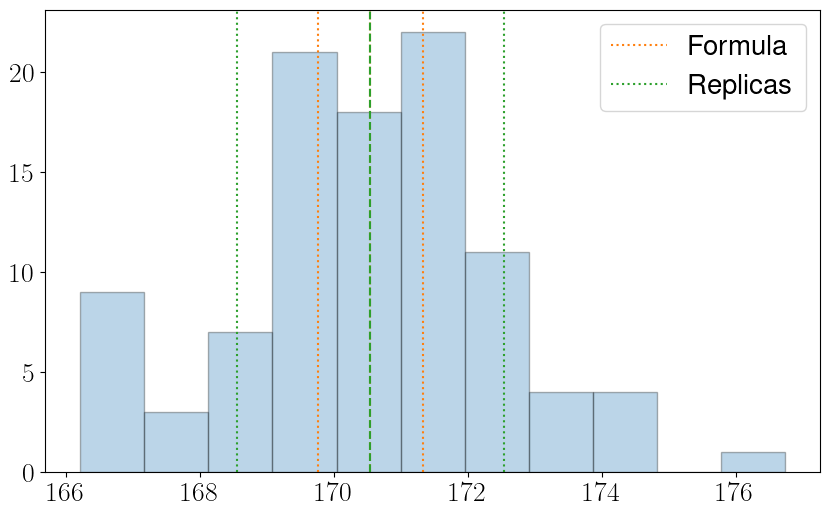

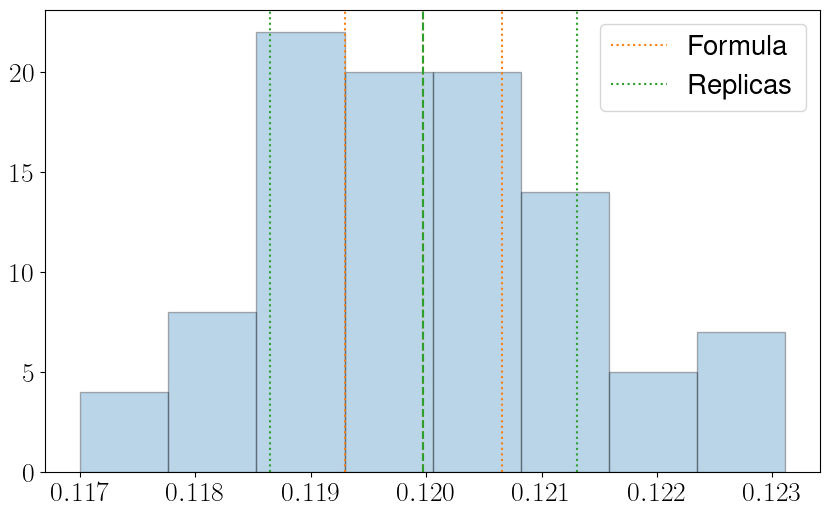

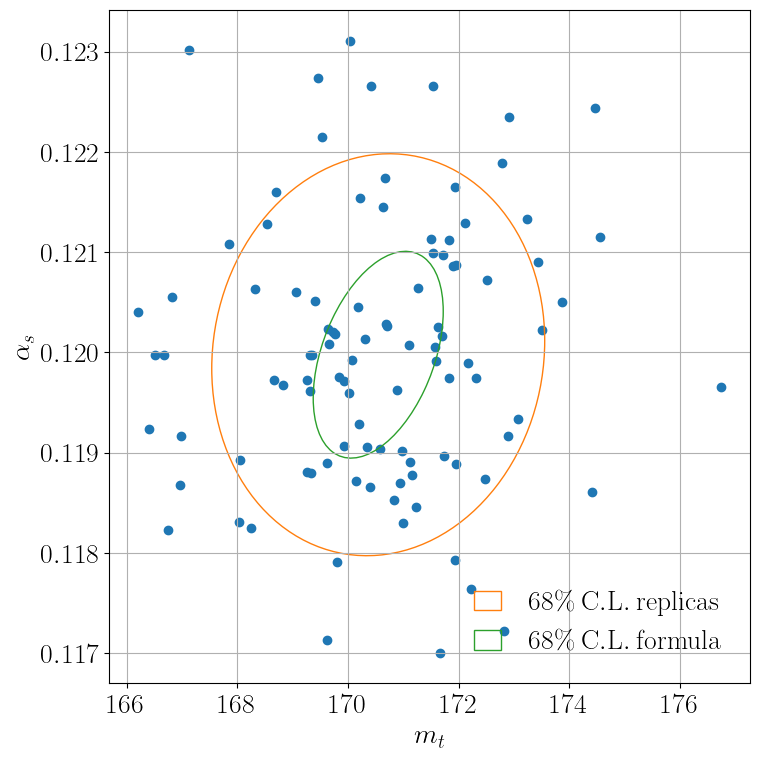

In [20]:
cov_reps = S_hat @ invcov @ X @ invcov @ S_hat.T + S_hat @ invcov @ S_hat.T - 2 * S_hat @ invcov @ Y @ invcov @ S_hat.T 
plot_histograms(pred, P_tilde, pred_reps.values, np.cov(pred_reps))